In [1]:
# %matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
path = "datasets/Hirano3D/"
# data_path = Path(PATH)

In [4]:
_clss = {'NM17-002': 0,
         'Ctrl-AK': 0,
         'GUK1-D': 1, 
         'GUK1-R': 1,
         'MFN2-1': 2,
         'VCP-1': 3}

#### CV generation via sklearn, Multilabel implementation by trent-b, or FastAi

Both libraries seem to be completely useless... can just use native fastai function: get_cv_idxs().<br>
However, get_cv_idxs() does NOT shuffle...!

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

def get_label_stratified_CV_idxs2(csv_path):
    
    _all_labels = pd.read_csv(csv_path)
    arr = _all_labels.values

    X = arr[:,0]
    y = arr[:,1:]
    
    ### sklearn.model_selection.StratifiedKFold
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    
    for train_index, val_index in sss.split(X, y):
        trn_idxs = train_index
        val_idxs = val_index
    
    print(f"""Train label-distribution:\n"""
          f"""{pd.Series(arr[:,1][trn_idxs]).value_counts()}""")
    print(f"""Val label-distribution:\n"""
          f"""{pd.Series(arr[:,1][val_idxs]).value_counts()}""")
    
    return trn_idxs, val_idxs


from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

def get_label_stratified_CV_idxs(csv_path):
    
    _all_labels = pd.read_csv(csv_path)
#     _all_labels['fake'] = pd.Series(np.zeros(len(_all_labels), dtype=int)) #need fake secondary-label column
    _all_labels['fake'] = _all_labels.Targets.copy() #need fake secondary-label column
    arr = _all_labels.values

    X = arr[:,0]
    y = arr[:,1:]
    
    ### Iterative stratification library: https://github.com/trent-b/iterative-stratification
    msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    
    for train_index, val_index in msss.split(X, y):
        trn_idxs = train_index
        val_idxs = val_index
    
    print(f"""Train label-distribution:\n"""
          f"""{pd.Series(arr[:,1][trn_idxs]).value_counts()}""")
    print(f"""Val label-distribution:\n"""
          f"""{pd.Series(arr[:,1][val_idxs]).value_counts()}""")
    
    return trn_idxs, val_idxs

In [ ]:
### used atm...
# csv_path = path + 'multi_folder_Hirano3D_v1.csv'
# trn_idxs, val_idxs = get_label_stratified_CV_idxs2(csv_path)

In [5]:
import pickle

# idxs_dict = {'trn_idxs': trn_idxs, 'val_idxs': val_idxs}

# with open('datasets/Hirano3D/tmp/Hirano3D_Res18_local_v2_idxs.pkl', 'wb') as handle:
#     pickle.dump(idxs_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('datasets/Hirano3D/tmp/Hirano3D_Res18_local_v2_idxs.pkl', 'rb') as handle:
    idxs_dict_load = pickle.load(handle)
    
val_idxs_loaded = idxs_dict_load['val_idxs']

In [ ]:
# csv_path = path + 'multi_folder_Hirano3D_02.csv'
# trn_idxs, val_idxs = get_label_stratified_CV_idxs(csv_path)

In [ ]:
# setting up a list of a random 20% of images in train as the validation set

# lbl_csv = path + 'multi_folder_Hirano3D_02.csv'
# n = len(list(open(lbl_csv))) -1
# val_idxs = get_cv_idxs(n, val_pct=0.2)


# # Count labels
# # _all_labels = pd.read_csv(PATH + 'multi_folder_Hirano3D_02.csv')
# # print(_all_labels.Targets.value_counts())

# _arr = _all_labels.values
# _val_labels = pd.DataFrame(_arr[val_idxs], columns=['Id','Targets'])
# print(_val_labels.Targets.value_counts())

### Define Dataloader:

In [6]:
def get_data(path, lbl_csv, val_idxs, sz, bs, aug_tfms):

    tfms = tfms_with_IntNorm(sz, aug_tfms=aug_tfms, crop_type=CropType.CENTER)
    data = ImageClassifierData.from_csv(PATH, 'data', lbl_csv, 
                                        val_idxs = val_idxs,
                                        test_name='data/8bit_Hirano3D_MaxP_GRFB_test_512', 
                                        tfms=tfms, bs=bs, suffix = '.tif', 
                                        balance=True, num_workers=0)
    return data

In [7]:
PATH = "datasets/Hirano3D"
# data_path = Path(PATH)

In [8]:
# define augmentations
augs = [RandomDihedral()]
NUM_CLASSES = 4
bs = 32
sz = [4,338,338]
lbl_csv = path + '8bit_multi_folder_Hirano3D_v1.csv'
# initialize data object
data = get_data(PATH, lbl_csv, val_idxs_loaded, sz, bs, aug_tfms = augs)

val_crop is: 2
Calculating weights...
one-hot encoding single-labels...
Weights calculated successfully!
Using WeightedRandomSampler


### inpsect data_loaders

In [ ]:
x, y = next(iter(data.trn_dl))
# x_test, y_test = next(iter(data.test_dl))

In [ ]:
plt.imshow(to_np(x)[5][2])

In [ ]:
# loading epoch for manual inspection...

In [ ]:
def load_epoch(dl = data.trn_dl):
    
    batch = iter(dl)

    xs = []
    ys = []

#     for b in range(0,len(dl)):
    for b in range(0,10):

        x_, y_ = next(batch)
        x_np, y_np = to_np(x_), to_np(y_)
        xs.append(x_np)
        ys.append(y_np)

    return np.vstack(xs), np.concatenate(ys)


### inpsecting loaded images and labels

In [ ]:
def to_label(y):
    ind = [i for i, p in enumerate(y) if y[i]==1]
    return(ind)

In [ ]:
# inspect train images
plt.style.use('seaborn-white')

idx = 2

im = to_np(x)[idx]

lbl = to_np(y)[idx]
# lbl = to_label(to_np(y)[idx])
print(lbl)

fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    ax.imshow(im[i])

In [ ]:
# inspect test images
plt.style.use('seaborn-white')

idx = 3

im = to_np(x_test)[idx]

# lbl = to_label(to_np(y)[idx])
# print(lbl)

fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    ax.imshow(im[i])

# training

In [ ]:
torch.cuda.is_available()

In [9]:
# base-model

arch = resnet18_c
# arch = resnet50
learn = ConvLearner.pretrained(arch, data, ps=0, opt_fn=optim.Adam, pretrained=False)

In [10]:
# additional parameters

wd=1e-5 # weight-decay/L2 regularization 
# learn.metrics = [accuracy_thresh(0.5),f1_macro]

In [11]:
learn.unfreeze()

In [ ]:
learn.summary()

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
# training loops:

In [12]:
%time learn.fit(1e-2, 2, cycle_len=8, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='Hirano3D_Res18_local_v2_1')

EPOCH 0 ---------------------------------------- STEP 0                                                                                                                                                                                      
epoch      trn_loss   val_loss   accuracy   
    0      1.471674   2.780059   0.204819  
EPOCH 1 ---------------------------------------- STEP 1                                                                                                                                                                                      
    1      1.475119   1.946266   0.204819  
EPOCH 2 ---------------------------------------- STEP 2                                                                                                                                                                                      
    2      1.439953   2.067862   0.204819  
EPOCH 3 ---------------------------------------- STEP 3                                                      

[array([1.12229]), 0.5060240963855421]

In [13]:
%time learn.fit(1e-3, 1, cycle_len=16, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='Hirano3D_Res18_local_v2_2')

EPOCH 0 ---------------------------------------- STEP 16                                                                                                                                                                                     
epoch      trn_loss   val_loss   accuracy   
    0      1.090121   1.207424   0.475904  
EPOCH 1 ---------------------------------------- STEP 17                                                                                                                                                                                     
    1      1.077934   1.294012   0.475904  
EPOCH 2 ---------------------------------------- STEP 18                                                                                                                                                                                     
    2      1.077383   1.39266    0.433735  
EPOCH 3 ---------------------------------------- STEP 19                                                     

[array([1.08367]), 0.5542168681880077]

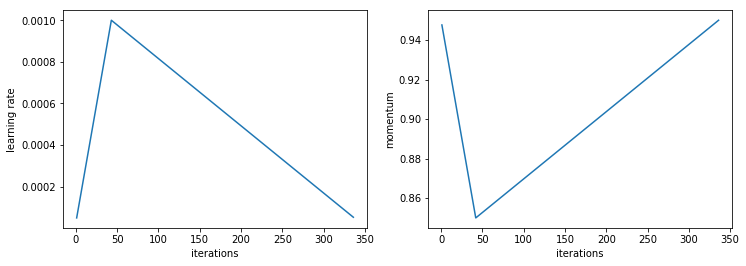

In [14]:
learn.sched.plot_lr()

In [15]:
%time learn.fit(6e-4, 1, cycle_len=16, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='Hirano3D_Res18_local_v2_3')

EPOCH 0 ---------------------------------------- STEP 32                                                                                                                                                                                     
epoch      trn_loss   val_loss   accuracy   
    0      0.745319   1.155481   0.536145  
EPOCH 1 ---------------------------------------- STEP 33                                                                                                                                                                                     
    1      0.747295   1.297986   0.506024  
EPOCH 2 ---------------------------------------- STEP 34                                                                                                                                                                                     
    2      0.775061   1.192174   0.536145  
EPOCH 3 ---------------------------------------- STEP 35                                                     

[array([1.10893]), 0.5542168667517513]

In [17]:
learn.load('Hirano3D_Res18_local_v2_3')

In [18]:
%time learn.fit(1e-3, 2, cycle_len=8, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='Hirano3D_Res18_local_v2_4')

EPOCH 0 ---------------------------------------- STEP 112                                                                                                                                                                                    
epoch      trn_loss   val_loss   accuracy   
    0      0.598869   1.384671   0.506024  
EPOCH 1 ---------------------------------------- STEP 113                                                                                                                                                                                    
    1      0.6663     1.415624   0.457831  
EPOCH 2 ---------------------------------------- STEP 114                                                                                                                                                                                    
    2      0.749035   1.355241   0.445783  
EPOCH 3 ---------------------------------------- STEP 115                                                    

[array([1.11126]), 0.6084337342216308]

In [ ]:
%time learn.fit(2e-5, 1, cycle_len=8, cycle_mult=2, wds=wd, use_wd_sched=True)

In [ ]:
lr = (5e-4, 1e-3, 5e-3)

In [ ]:
sz = [4,516, 516]
learn.set_data(get_data(PATH, lbl_csv, val_idxs, sz, bs, aug_tfms = augs))

In [ ]:
%time learn.fit(1e-3, 1, cycle_len=8, cycle_mult=2, wds=wd, use_wd_sched=True)

In [ ]:
%time learn.fit(1e-3, 2, cycle_len=8, wds=wd, use_wd_sched=True)

In [ ]:
learn.save('Hirano3D_v1_ResNet18_512_72')

In [ ]:
learn.load('Hirano3D_v1_ResNet18_512_72')

## test-predictions

In [ ]:
log_preds, y = learn.predict_with_targs()
preds = np.argmax(log_preds, axis=1)
print(preds)

In [ ]:
log_preds, y =  learn.TTA()

In [ ]:
# Plot confusion matrix 
plt.style.use('seaborn-white')
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

In [ ]:
log_preds, y =  learn.TTA(is_test=True)
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
print(preds)

In [ ]:
# function to be called by register_forward_hook

def get_embeddings(layer_name):
    def register_hook(layer_name):
        def get_embedding(layer, inp, outp):
            tmp = inp[0]
            embedding.append(tmp)

        hook = layer.register_forward_hook(get_embedding) 
        
        for i in ['trn', 'val', 'test']:
            embedding = []
            preds, y = learn.predict_with_targs(i)
            
            # populating dict, consiting of [0]: preds, [1]: y, [2]: activations[layer]
            embeddings[i] = [preds, y, np.vstack(to_np(embedding))]
            
        hook.remove()
        
    embeddings = {}    
    layer = learn.models.model._modules.get(layer_name)
    register_hook(layer)
    
    return embeddings

In [ ]:
embeddings = get_embeddings('14')

In [ ]:
# unpacking embeddings

embs_trn = embeddings['trn'][2]
y_trn = embeddings['trn'][1]

embs_val = embeddings['val'][2]
y_val = embeddings['val'][1]

embs_test = embeddings['test'][2]
y_test = embeddings['test'][1]

print(embs_trn.shape)
print(embs_val.shape)
print(embs_test.shape)

print(y_trn.shape)
print(y_val.shape)
print(y_test.shape)


In [ ]:
import umap

In [ ]:
UMAP_trn_embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.3,
                      metric='correlation').fit(embs_trn)

UMAP_trn = UMAP_trn_embedding.embedding_
UMAP_val = UMAP_trn_embedding.transform(embs_val)
UMAP_test = UMAP_trn_embedding.transform(embs_test)

In [ ]:
# data.test_ds.fnames

In [ ]:
y_test = np.zeros(60)
y_test[:30] = y_test[:30] +1 
y_test

In [ ]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in range(4):
    trn_UMAP_cls = UMAP_trn[y_trn == i]

    axarr[0].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5)
    axarr[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if i == 0:
        axarr[1].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5)

    axarr[0].set_xlim(-10,5)
    axarr[0].set_ylim(-5,8)
    
for i in [0,1]:
    test_UMAP_cls = UMAP_test[y_test == i]
    
    axarr[1].scatter(test_UMAP_cls[:,compA], test_UMAP_cls[:,compB], s = 5)
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axarr[1].set_xlim(-10,5)
    axarr[1].set_ylim(-5,8)


In [ ]:
def opt_th(preds, targs, start=0.2, end=0.6, step=0.05):
    ths = np.arange(start,end,step)
    res = [f1_macro(preds, targs, thresh=th, kind='macro') for th in ths]
    idx = np.argmax(res)
    return ths[idx], res

In [ ]:
# get train predictions

preds_trn, targs_trn =  learn.predict_with_targs('trn')

preds_trn_torch = torch.from_numpy(preds_trn)
targs_trn_torch = torch.from_numpy(targs_trn)

opt_th(preds_trn_torch, targs_trn_torch)

In [ ]:
print(preds_val_torch[0])
print(preds_trn_torch[0])

In [ ]:
# get val predictions

preds_val, targs_val =  learn.predict_with_targs('val')

preds_val_torch = torch.from_numpy(preds_val)
targs_val_torch = torch.from_numpy(targs_val)

opt_th(preds_val_torch, targs_val_torch)

In [ ]:
# get test predictions

preds_test, targs_test =  learn.predict_with_targs('test')

In [ ]:
targs_test[:50]

In [ ]:
def load_epoch(dl = data.trn_dl):
    
    batch = iter(dl)

    xs = []
    ys = []

#     for b in range(0,len(dl)):
    for b in range(0,10):

        x_, y_ = next(batch)
        x_np, y_np = to_np(x_), to_np(y_)
        xs.append(x_np)
        ys.append(y_np)

    return np.vstack(xs), np.concatenate(ys)

In [ ]:
data.test_dl.sampler

In [ ]:
test_names = data.test_ds.fnames
test_names[:10]

In [ ]:
def create_submission(preds_file, output_name, th = 0.3, TTA=False):
    
    # creating submission file
    
    if TTA:
        preds = preds_file.mean(axis=0)
        print('TTA:',preds.shape)
    else: preds = preds_file
    
    clss = np.arange(0, len(data.classes)) # get class indeces
    res = np.array([' '.join(np.char.mod('%d', clss[np.where(p > th)])) for p in preds]) # generating output

    # ensure that there are no empty cells: in case no value > thresh, fill in with argmax()
    for i in range(res.shape[0]):
        if res[i] == '':
            res[i] = preds[i].argmax()

    # getting image Ids
    fnames = np.array([os.path.basename(im).split('.')[0] for im in data.test_ds.fnames])

    # creating submission file
    sub_df = pd.DataFrame(res, index=fnames, columns=['Predicted'])
    sub_df.to_csv(output_name, index_label='Id')

In [ ]:
submission_name = PATH + 'submissions/Res18_pre_0.42_t-03.csv'

create_submission(log_preds, submission_name, th=0.3, TTA=True)

## other stuff

In [ ]:
# List of label identities:

cell_location_label = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [ ]:
# from sklearn.metrics import f1_score

# thresholds = np.linspace(0, 1, 1000)
# score = 0.0
# test_threshold=0.5*np.ones(28)
# best_threshold=np.zeros(28)
# best_val = np.zeros(28)
# for i in range(28):
#     for threshold in thresholds:
#         test_threshold[i] = threshold
#         max_val = np.max(preds_y)
#         val_predict = (preds_y > test_threshold)
#         score = f1_score(valid_y > 0.5, val_predict, average='macro')
#         if score > best_val[i]:
#             best_threshold[i] = threshold
#             best_val[i] = score
#     print("Threshold[%d] %0.6f, F1: %0.6f" % (i,best_threshold[i],best_val[i]))
#     test_threshold[i] = best_threshold[i]
# print("Best threshold: ")
# print(best_threshold)
# print("Best f1:")
# print(best_val)